# AM1-BCC restriction scheme project

## TODO
1) create functionality to use antechamber

    a) will take in most file formats, perform am1-bcc simulation, and store results in tmp folder

    b) should sort and rename output files into a system of folders 

    c) names should be duplicates of the inputted file name

2) use py3Dmol to visualize the results

    a) how to create easy-to-compare plots (ie. similar rotation, viewing)

3) use isomorphism or some similar metric to find differences in connectivity

4) First, test on examples provided by Jeffrey. Next, test on all conformers of provided proteins 

In [1]:
import os
from pathlib import Path
import shutil
import subprocess
import py3Dmol
from openff.toolkit.topology.molecule import FrozenMolecule, Molecule
from openff.toolkit.utils.toolkits import RDKitToolkitWrapper, OpenEyeToolkitWrapper
from distutils.spawn import find_executable
import tempfile
from openff.toolkit.utils.utils import temporary_cd   # this is really cool btw
from simtk import unit
from bcc_utils import *
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import numpy as np

# reproducing cases
First, we will look at some examples provided by Jeffrey.
Note: the `run_am1_bcc()` function handles offmols with multiple conformers. Results from different conformers are placed in subdirectories starting at directory `conf0` and continuing on to  `conf1`, `conf2`, and so on. 

`run_am1_bcc` will also use the isomorphism checker provided in the openff toolkit to test if a substantial change has occurred. For now, an error message is printed, and error message is returned in the form of a dictionary. 

In [2]:
molecule = Molecule.from_smiles('[c:1]1([H:17])[c:4]([H:5])[c:2]([H:18])[c:7]([C:13]2([H:28])[C:9]([H:20])([H:21])[C:11]([H:24])([H:25])[N+:14]([H:29])([H:30])[C:12]([H:26])([H:27])[C:10]2([H:22])[H:23])[c:3]([H:19])[c:6]1[C:8]([O-:15])=[O:16]')
molecule.name = "original"
molecule.generate_conformers(n_conformers=5)
status = run_am1_bcc(molecule, output_dir='reproducing_cases/original')

print(status)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)
 - Atom C (index 27)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. 

   rdkit qcelemental
0   True        True
1  False       False


In [3]:
# the inputs are similar 
input_file1 = 'reproducing_cases/original/conf0/input_original.sdf'
input_file2 = 'reproducing_cases/original/conf1/input_original.sdf'

viewer1 = mol_file_viewer(input_file1)
viewer2 = mol_file_viewer(input_file2, highlight_idx=[15])
print('first conformer (original)')
viewer1.show()
print('second conformer (idx 15 highlighted from now on)')
viewer2.show()

print(type(viewer1))


first conformer (original)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

second conformer (idx 15 highlighted from now on)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

<class 'py3Dmol.view'>


In [4]:
input_file1 = 'reproducing_cases/original/conf0/sqm_original.pdb'
input_file2 = 'reproducing_cases/original/conf1/sqm_original.pdb'

viewer1 = mol_file_viewer(input_file1, highlight_idx=[15, 16, 17])
viewer2 = mol_file_viewer(input_file2, highlight_idx=[15, 16])
print('first conformer (original)')
viewer1.show()
print('second conformer')
viewer2.show()

first conformer (original)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

second conformer


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Comparing Partial Charges (Amber vs. Openeye)
OpenEye applies light restraints to favor the starting geometry of the molecule. Because of this, the openeye toolkit can be used as rough estimate at "better" behavior. 

In [5]:
# a quick plot confirms the visual inspection of the generated partial charges 
def plot_df(df):
    plt.figure(1, dpi=100)
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlabel('atom idx')
    ax1.set_ylabel('partial charge')
    ax1.set_title('partial charge assignment methods (oe vs amber)')

    colors = ['k', 'k', 'r', 'm']
    colors = dict(zip(df.columns, colors))
    for column in df.columns:
        ax1.scatter(df.index, df[column], label=column, s=8, alpha=0.7, c=colors[column])
    plt.legend()

    plt.figure(2, dpi=100)
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlabel('atom idx')
    ax1.set_ylabel('partial charge difference')
    ax1.set_title('partial charge assignment internal difference (openeye)')

    differences = df['oe_conf0'] - df['oe_conf1']
    ax1.scatter(differences.index, differences, label=column, s=8, alpha=0.7)
    ax1.hlines(y=0, xmin=0, xmax=len(differences), colors='r')

    plt.figure(3, dpi=100)
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlabel('atom idx')
    ax1.set_ylabel('partial charge difference')
    ax1.set_title('partial charge assignment internal difference (amber)')

    differences = df['amber_conf0'] - df['amber_conf1']
    ax1.scatter(differences.index, differences, label=column, s=8, alpha=0.7)
    ax1.hlines(y=0, xmin=0, xmax=len(differences), colors='r')


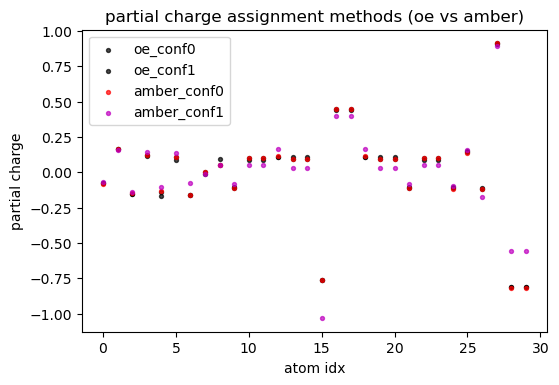

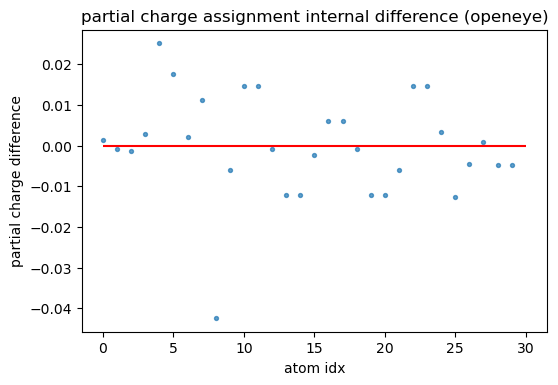

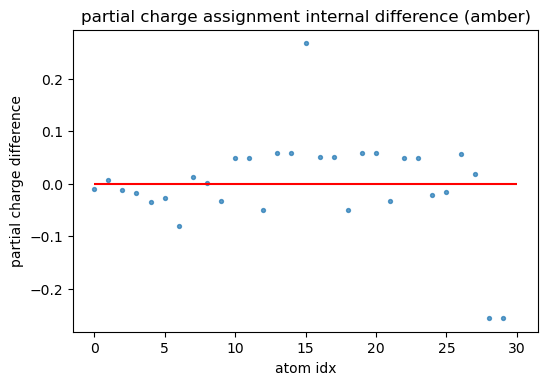

In [6]:
df_original = pd.DataFrame(columns=['oe_conf0', 'oe_conf1', 'amber_conf0', 'amber_conf1'])

# read in already-calculated amber charges
with open("reproducing_cases/original/conf0/charges_original.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_original['amber_conf0'] = charges

with open("reproducing_cases/original/conf1/charges_original.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_original['amber_conf1'] = charges

# generate partial charges from openeye quacpac through OpenEyeToolkitWrapper, which already does everything
# we need to demonstrate 
conf_num = 0
for conf in molecule.conformers:
    mol_conf = Molecule(molecule)
    mol_conf._conformers = [conf]
    mol_conf.assign_partial_charges(partial_charge_method='am1bcc', use_conformers=[conf], toolkit_registry=OpenEyeToolkitWrapper())
    df_original[f'oe_conf{conf_num}'] = mol_conf.partial_charges._value
    conf_num += 1
plot_df(df_original)

# Solutions
Using this initial test case, each of the following solutions can be quickly tested. Even though these solutions will only be needed in cases of molecular rearrangement, I found it useful to test the methods on both conformers. This way, differences in the calculated charge can be compared for cases where the AM1 method does not break. This can later be reproduced with a larger dataset of molecules, but for now, the two previous conformers will be used.

## 1) Restricting all geoemtry during AM1 charge simulation
Here, the maxcyc parameter can be set to 0 to restrict all geometry minimizations. This is definitely not an ideal solution, but is a good first try.  

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral cent

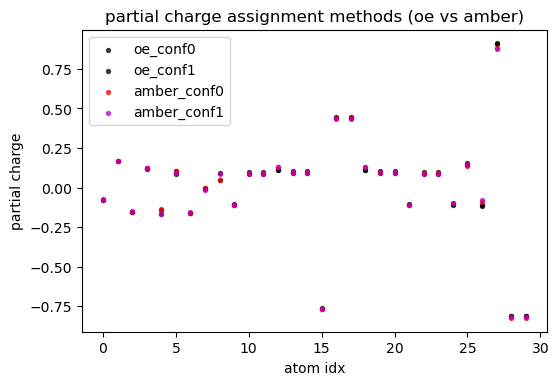

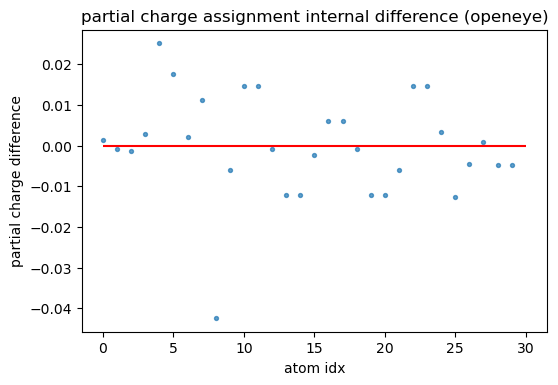

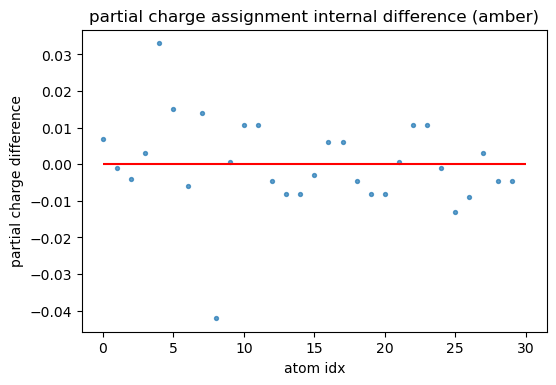

In [7]:
molecule = Molecule.from_smiles('[c:1]1([H:17])[c:4]([H:5])[c:2]([H:18])[c:7]([C:13]2([H:28])[C:9]([H:20])([H:21])[C:11]([H:24])([H:25])[N+:14]([H:29])([H:30])[C:12]([H:26])([H:27])[C:10]2([H:22])[H:23])[c:3]([H:19])[c:6]1[C:8]([O-:15])=[O:16]')
molecule.name = "maxcyc_0"
molecule.generate_conformers(n_conformers=5)
args = ["-ek", "qm_theory='AM1', grms_tol=0.0005, scfconv=1.d-10,                               ndiis_attempts=700, qmcharge=0, maxcyc=0"]
status = run_am1_bcc(molecule, output_dir='reproducing_cases/maxcyc_0', arguments=args)

# the same brief comparison to openeye was run as before... 

df_maxcyc_0 = pd.DataFrame(columns=['oe_conf0', 'oe_conf1', 'amber_conf0', 'amber_conf1'])

# read in already-calculated amber charges
with open("reproducing_cases/maxcyc_0/conf0/charges_maxcyc_0.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_maxcyc_0['amber_conf0'] = charges

with open("reproducing_cases/maxcyc_0/conf1/charges_maxcyc_0.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_maxcyc_0['amber_conf1'] = charges

# generate partial charges from openeye quacpac through OpenEyeToolkitWrapper, which already does everything
# we need to demonstrate 
conf_num = 0
for conf in molecule.conformers:
    mol_conf = Molecule(molecule)
    mol_conf._conformers = [conf]
    mol_conf.assign_partial_charges(partial_charge_method='am1bcc', use_conformers=[conf], toolkit_registry=OpenEyeToolkitWrapper())
    df_maxcyc_0[f'oe_conf{conf_num}'] = mol_conf.partial_charges._value
    conf_num += 1
plot_df(df_maxcyc_0)

In [8]:
input_file1 = 'reproducing_cases/maxcyc_0/conf1/input_maxcyc_0.sdf'
input_file2 = 'reproducing_cases/maxcyc_0/conf1/sqm_maxcyc_0.pdb'

viewer1 = mol_file_viewer(input_file1, highlight_idx=[15])
viewer2 = mol_file_viewer(input_file2, highlight_idx=[15])
print('second conformer (before)')
viewer1.show()
print('second conformer (after) \n no minimization or geometry change')
viewer2.show()

second conformer (before)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

second conformer (after) 
 no minimization or geometry change


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2) Using SHAKE for any proton rearrangments 
Since proton rearrangements are bound to occur, SHAKE may offer a quick solution to a common problem

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral cent

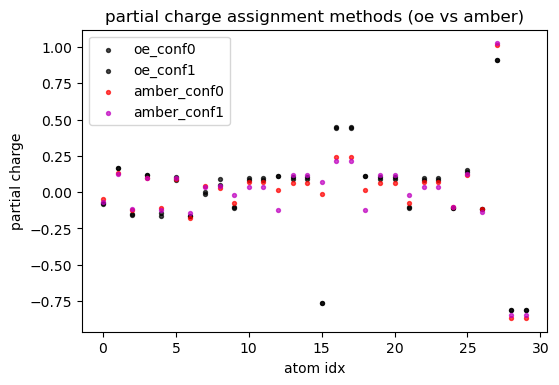

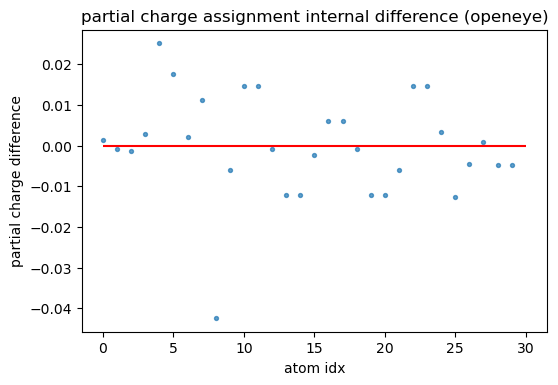

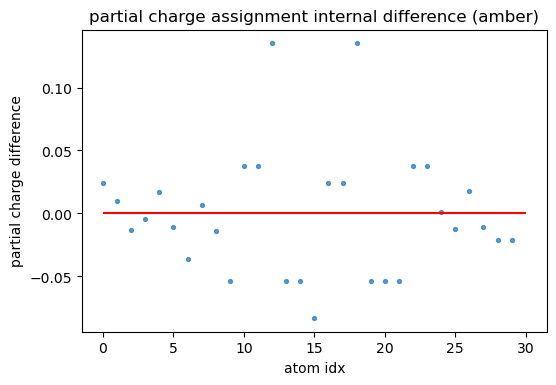

In [9]:
molecule = Molecule.from_smiles('[c:1]1([H:17])[c:4]([H:5])[c:2]([H:18])[c:7]([C:13]2([H:28])[C:9]([H:20])([H:21])[C:11]([H:24])([H:25])[N+:14]([H:29])([H:30])[C:12]([H:26])([H:27])[C:10]2([H:22])[H:23])[c:3]([H:19])[c:6]1[C:8]([O-:15])=[O:16]')
molecule.name = "shake"
molecule.generate_conformers(n_conformers=5)
status = run_am1_bcc(molecule, output_dir='reproducing_cases/shake', arguments=["-ek", "qmshake=1"])

# the same brief comparison to openeye was run as before... 

df_shake = pd.DataFrame(columns=['oe_conf0', 'oe_conf1', 'amber_conf0', 'amber_conf1'])

# read in already-calculated amber charges
with open("reproducing_cases/shake/conf0/charges_shake.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_shake['amber_conf0'] = charges

with open("reproducing_cases/shake/conf1/charges_shake.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_shake['amber_conf1'] = charges

# generate partial charges from openeye quacpac through OpenEyeToolkitWrapper, which already does everything
# we need to demonstrate 
conf_num = 0
for conf in molecule.conformers:
    mol_conf = Molecule(molecule)
    mol_conf._conformers = [conf]
    mol_conf.assign_partial_charges(partial_charge_method='am1bcc', use_conformers=[conf], toolkit_registry=OpenEyeToolkitWrapper())
    df_shake[f'oe_conf{conf_num}'] = mol_conf.partial_charges._value
    
    conf_num += 1
plot_df(df_shake)



In [10]:
input_file1 = 'reproducing_cases/shake/conf1/input_shake.sdf'
input_file2 = 'reproducing_cases/shake/conf1/sqm_shake.pdb'

viewer1 = mol_file_viewer(input_file1, highlight_idx=[15])
viewer2 = mol_file_viewer(input_file2, highlight_idx=[15])
print('second conformer (before)')
viewer1.show()
print('second conformer (after) \n minimization with shake applied')
viewer2.show()

second conformer (before)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

second conformer (after) 
 minimization with shake applied


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3) Geometry minimization followed by method #1
This approach speaks for itself. Instead of having AM1 minimize the geometry with QM, we can first use non-QM simulations to minimize the geometry and follow up with the AM1 charge simulation. For the geometry minimization, I used openff-1.3.0.offxml for the initial minimization. 

<class 'numpy.ndarray'>


/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      3  C   UNL     1      -2.034  -2.189  -3.455  0.00  0.00              , ATOM      1  C   UNL     1      -3.104  -1.333  -3.714  0.00  0.00              )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      4  H   UNL     1      -1.614  -2.791  -4.256  0.00  0.00              , ATOM      2  H   UNL     1      -3.510  -1.276  -4.721  0.00  0.00              )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/op

221.34788087042512 kJ/mol
[Vec3(x=-0.3122646261898862, y=-0.1308551845957825, z=-0.36783566090578007), Vec3(x=-0.35660522684418827, y=-0.12140807832162798, z=-0.46675474344585066), Vec3(x=-0.20585093834689613, y=-0.21923645670049988, z=-0.34595751152611465), Vec3(x=-0.16762832364169886, y=-0.27848091905298344, z=-0.42851927936553236), Vec3(x=-0.14906977924751877, y=-0.23132502022156717, z=-0.21865100307330199), Vec3(x=-0.06670494687513634, y=-0.3005712301890871, z=-0.20408917480172645), Vec3(x=-0.19817381319093508, y=-0.15481032063964184, z=-0.11192963721600147), Vec3(x=-0.1380933808354698, y=-0.16639588280422907, z=0.02609809463410923), Vec3(x=-0.05832499357259866, y=-0.24149574158707637, z=0.02436046203229942), Vec3(x=-0.07636009291783227, y=-0.03165806681342777, z=0.06717776762992961), Vec3(x=0.007294213533757591, y=-0.008336896377944356, z=0.0004070599503637761), Vec3(x=-0.14959312091370044, y=0.048896983654227226, z=0.05561907025826394), Vec3(x=-0.02827797737652528, y=-0.035735762

/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      3  C   UNL     1      -1.530  -3.850   4.069  0.00  0.00              , ATOM      1  C   UNL     1      -2.169  -2.910   4.878  0.00  0.00              )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/openmm/app/internal/pdbstructure.py:537: UserWarning: WARNING: duplicate atom (ATOM      4  H   UNL     1      -1.398  -4.869   4.421  0.00  0.00              , ATOM      2  H   UNL     1      -2.533  -3.209   5.858  0.00  0.00              )
  warnings.warn("WARNING: duplicate atom (%s, %s)" % (atom, old_atom._pdb_string(old_atom.serial_number, atom.alternate_location_indicator)))
/home/coda3831/anaconda3/envs/openff-dev2/lib/python3.7/site-packages/simtk/op

216.9734251744664 kJ/mol
[Vec3(x=-0.21953852225050613, y=-0.31050027359764765, z=0.46545899726499174), Vec3(x=-0.24963258522834844, y=-0.3375413939314461, z=0.5664910803077168), Vec3(x=-0.23285055798501894, y=-0.40193767938542085, z=0.36049529646579687), Vec3(x=-0.27482641236598815, y=-0.5001706736646488, z=0.37999901720450957), Vec3(x=-0.19095944292757655, y=-0.3677334784064517, z=0.23149729196754204), Vec3(x=-0.20142553549758438, y=-0.44119585751264506, z=0.15221472066343944), Vec3(x=-0.13616453613471463, y=-0.24110377501171318, z=0.20473013173764473), Vec3(x=-0.08497573211673813, y=-0.209884950773734, z=0.0645800041273356), Vec3(x=-0.16516886549560178, y=-0.23488701139142473, z=-0.005741645012620722), Vec3(x=-0.04369472067795653, y=-0.06294242540646738, z=0.039971144911636995), Vec3(x=-0.02889870698827589, y=-0.04873373769124572, z=-0.0674901169944897), Vec3(x=-0.1256247954603583, y=0.0036663509089361794, z=0.06923206868428924), Vec3(x=0.08568155124635567, y=-0.022274080370688377, z

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 0)
 - Atom C (index 2)
 - Atom C (index 4)
 - Atom C (index 6)
 - Atom C (index 24)
 - Atom C (index 26)

Warning (not error because allow_undefined_stereo=True): Unable to make OFFMol from RDMol: RDMol has unspecified stereochemistry. Undefined chiral cent

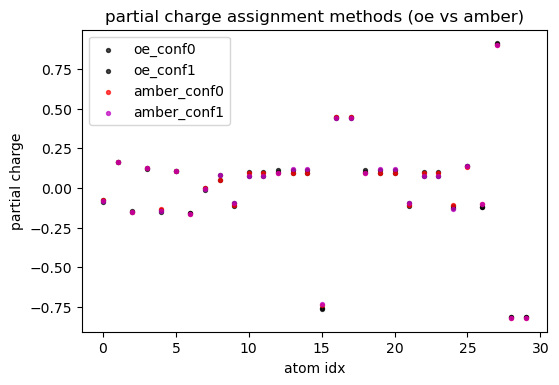

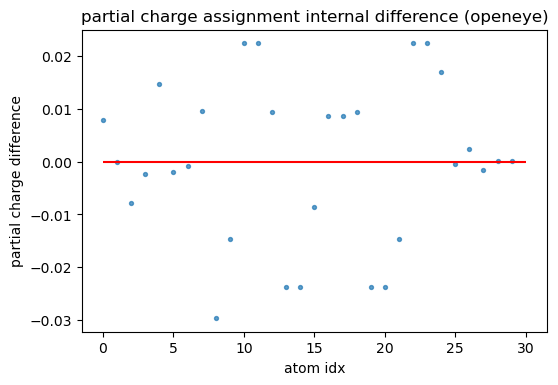

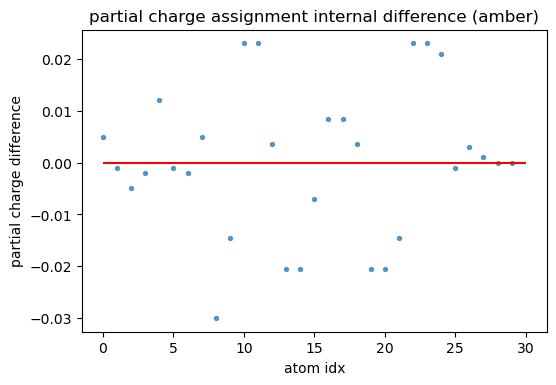

In [11]:
from simtk.openmm.app import PDBFile
from simtk import openmm, unit
from openff.toolkit.topology import Topology
from openff.toolkit.typing.engines.smirnoff import ForceField

molecule = Molecule.from_smiles('[c:1]1([H:17])[c:4]([H:5])[c:2]([H:18])[c:7]([C:13]2([H:28])[C:9]([H:20])([H:21])[C:11]([H:24])([H:25])[N+:14]([H:29])([H:30])[C:12]([H:26])([H:27])[C:10]2([H:22])[H:23])[c:3]([H:19])[c:6]1[C:8]([O-:15])=[O:16]')
molecule.name = "smirnoff"
molecule.generate_conformers(n_conformers=5)
conf_num = 0
conformers = []
for conf in molecule.conformers:
    with tempfile.TemporaryDirectory() as tmpdir:
        with temporary_cd(tmpdir):
            mol_conf = Molecule(molecule)
            mol_conf._conformers = [conf]
            print(type(conf._value))
            mol_conf.to_file(file_path='mol.pdb', file_format="PDB")
            pdbfile = PDBFile('mol.pdb')
            omm_topology = pdbfile.topology

            off_topology = mol_conf.to_topology()
            forcefield = ForceField('openff_unconstrained-1.3.0.offxml')
            system = forcefield.create_openmm_system(off_topology)
            time_step = 2*unit.femtoseconds  # simulation timestep
            temperature = 3000*unit.kelvin  # simulation temperature
            friction = 1/unit.picosecond  # collision rate
            integrator = openmm.LangevinIntegrator(temperature, friction, time_step)
            simulation = openmm.app.Simulation(omm_topology, system, integrator)
            positions = pdbfile.getPositions() 
            simulation.context.setPositions(positions)

            pdb_reporter = openmm.app.PDBReporter('trajectory.pdb', 10)
            simulation.reporters.append(pdb_reporter)
            
            simulation.minimizeEnergy(maxIterations=1000)
            st = simulation.context.getState(getPositions=True, getEnergy=True)
            print(st.getPotentialEnergy())
            print(st.getPositions())
            unitless_positions = []
            for vec in st.getPositions():
                x = vec.x * 10     # please don't let me forget this
                y = vec.y * 10     # how to do this in a... better... way 
                z = vec.z * 10
                unitless_positions.append([x, y, z])
            unitless_positions = np.array(unitless_positions)
            final_conf = unit.Quantity(unitless_positions, mol_conf._conformers[0].unit) # units should be angstrom
            conformers.append(final_conf)
    
molecule._conformers = conformers

args = ["-ek", "qm_theory='AM1', grms_tol=0.0005, scfconv=1.d-10,                               ndiis_attempts=700, qmcharge=0, maxcyc=0"]
status = run_am1_bcc(molecule, output_dir='reproducing_cases/smirnoff', arguments=args)

# the same brief comparison to openeye was run as before... 

df_smirnoff = pd.DataFrame(columns=['oe_conf0', 'oe_conf1', 'amber_conf0', 'amber_conf1'])

# read in already-calculated amber charges
with open("reproducing_cases/smirnoff/conf0/charges_smirnoff.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_smirnoff['amber_conf0'] = charges

with open("reproducing_cases/smirnoff/conf1/charges_smirnoff.txt", 'r') as ifile:
    charges = ifile.read()
charges = charges.split()
charges = [float(charge) for charge in charges]
df_smirnoff['amber_conf1'] = charges

# generate partial charges from openeye quacpac through OpenEyeToolkitWrapper, which already does everything
# we need to demonstrate 
conf_num = 0
for conf in molecule.conformers:
    mol_conf = Molecule(molecule)
    mol_conf._conformers = [conf]
    mol_conf.assign_partial_charges(partial_charge_method='am1bcc', use_conformers=[conf], toolkit_registry=OpenEyeToolkitWrapper())
    df_smirnoff[f'oe_conf{conf_num}'] = mol_conf.partial_charges._value
    conf_num += 1
plot_df(df_smirnoff)









In [12]:
input_file1 = 'reproducing_cases/smirnoff/conf1/input_smirnoff.sdf'
input_file2 = 'reproducing_cases/smirnoff/conf1/sqm_smirnoff.pdb'

viewer1 = mol_file_viewer(input_file1, highlight_idx=[15])
viewer2 = mol_file_viewer(input_file2, highlight_idx=[15])
print('second conformer (before)')
viewer1.show()
print('second conformer (after) \n smirnoff minimization followed by am1bcc')
viewer2.show()

second conformer (before)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

second conformer (after) 
 smirnoff minimization followed by am1bcc


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 4) geomeTRIC geometry restriction scheme
This approach is very broad and has potential for heavy optimizations. The first working code has been provided by Simon Boothroyd. 

## Comparing all methods 
First, lets see how the three methods treated conf0, the conformer that did not have any connectivity change. This could be considered a baseline. Even though these methods WOULD NOT be used on cases where he connectivity is left intact, it is still worthwhile so see how these methods affect the partial charges of a "typical" molecule. 

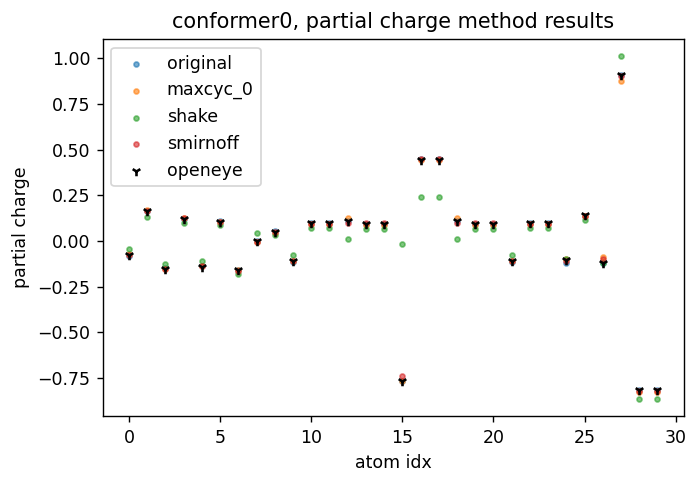

<Figure size 3600x2400 with 0 Axes>

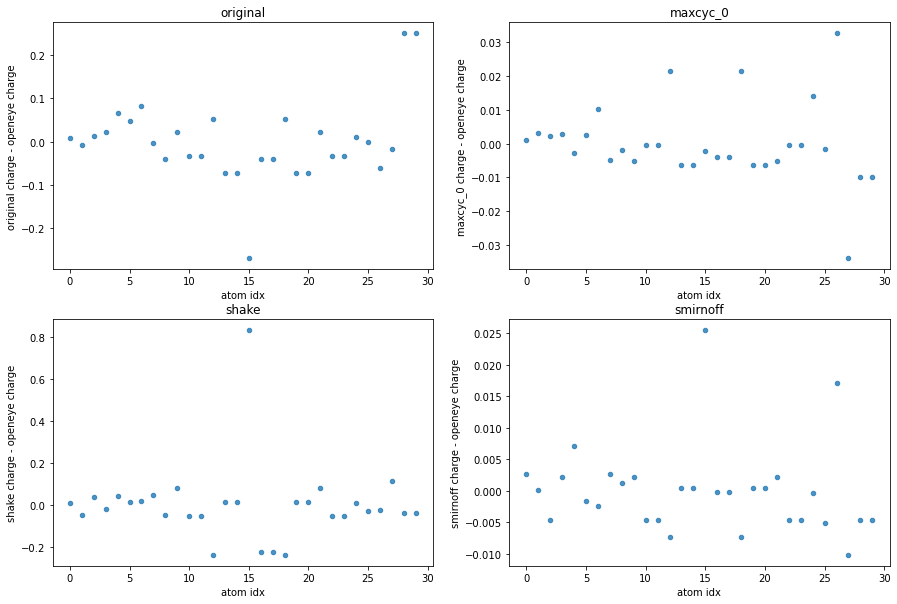

In [19]:
plt.figure(1, dpi=125)
ax1 = plt.subplot(1,1,1)
ax1.set_title("conformer0, partial charge method results")
ax1.set_xlabel("atom idx")
ax1.set_ylabel("partial charge")
amber_dfs = {'original': df_original,
             'maxcyc_0': df_maxcyc_0,
             'shake': df_shake,
             'smirnoff': df_smirnoff}
for method, df in amber_dfs.items():
    ax1.scatter(df.index, df['amber_conf0'], s=8, alpha=0.6, label=method)

ax1.scatter(df_original.index, df_original['oe_conf0'], s=30, alpha=1, label='openeye', marker="1", c='k')

plt.legend()

# using openeye as the "standard", we can look at the deviation from openeye results
plt.figure(2, dpi=600)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for ax, method, df in zip(axs.flat, amber_dfs.keys(), amber_dfs.values()):
    difference = df['amber_conf1'] - df['oe_conf1']
    ax.scatter(difference.index, difference, s=20, alpha=0.8)
    ax.set_title(method)
    ax.set_xlabel("atom idx")
    ax.set_ylabel(f"{method} charge - openeye charge")

plt.show()

<Figure size 432x288 with 0 Axes>

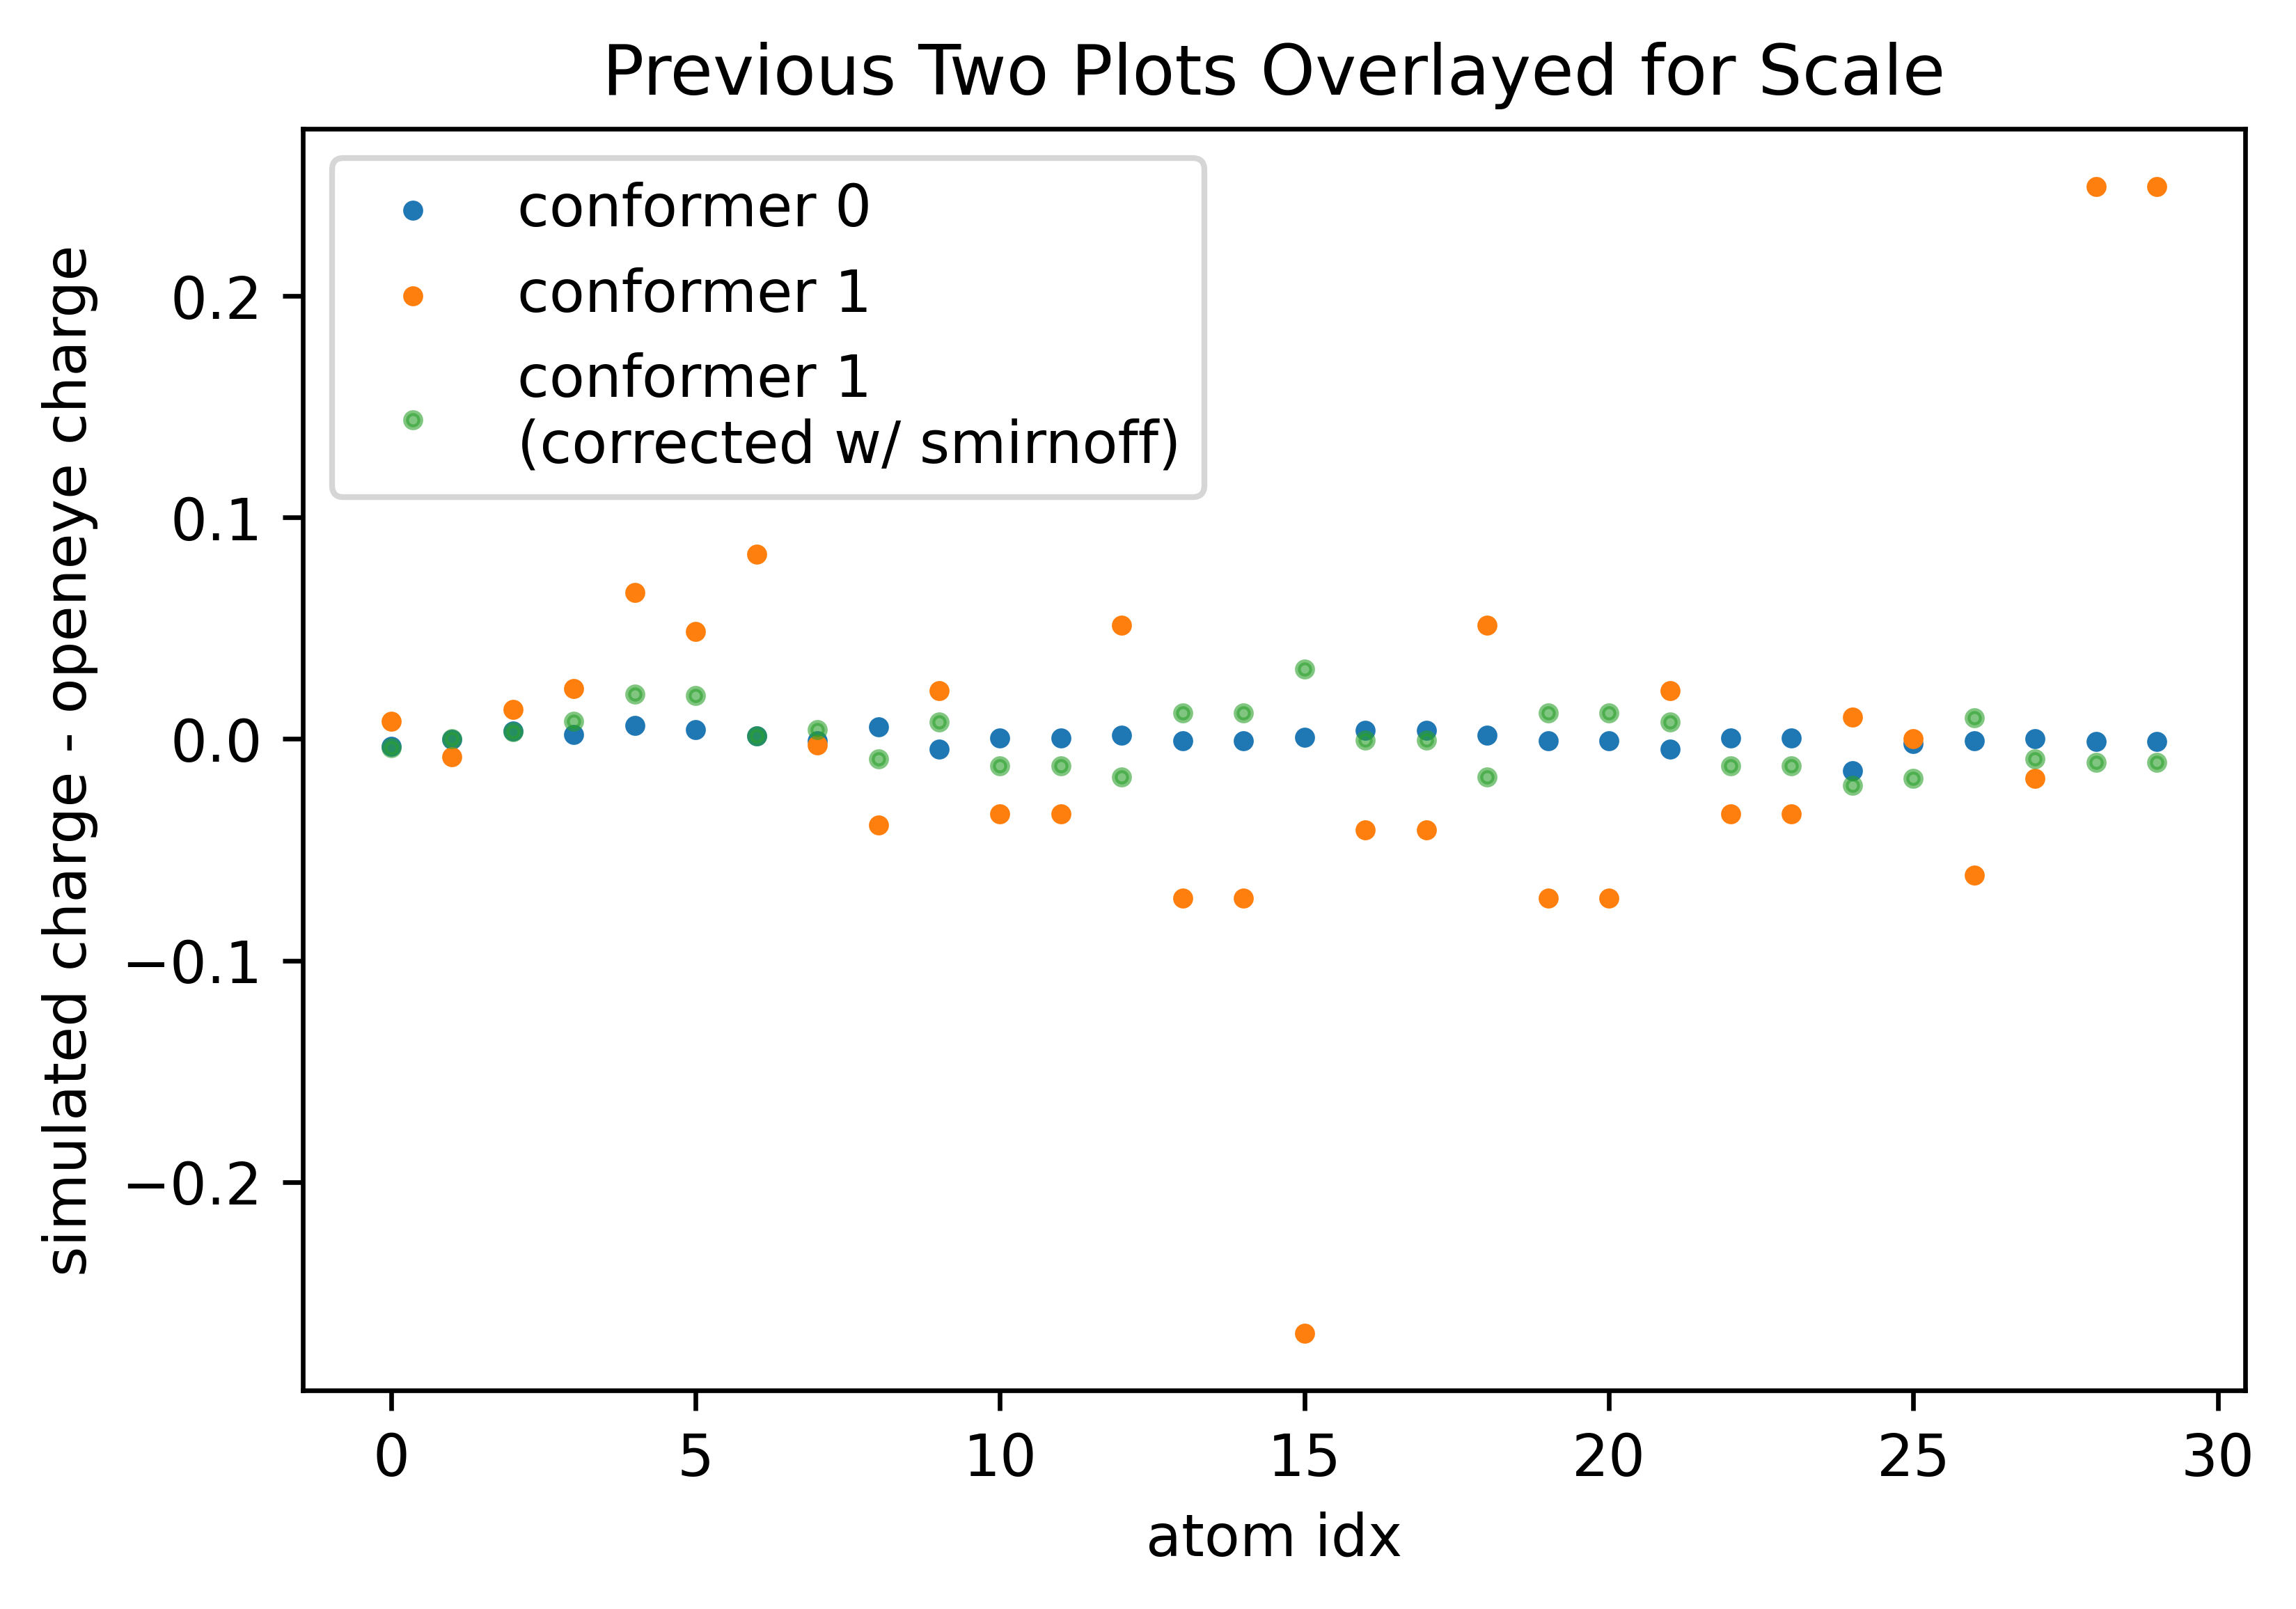

In [38]:
plt.clf()
plt.figure(4, dpi=600)
ax1 = plt.subplot(1,1,1)
ax1.set_xlabel("atom idx")
ax1.set_ylabel("simulated charge - openeye charge")
ax1.set_title("Previous Two Plots Overlayed for Scale")
amber_dfs = {'original': df_original}

for i in range(0,2):
    difference = df_original[f'amber_conf{i}'] - df_original[f'oe_conf{i}']
    ax1.scatter(difference.index, difference, s=6, label=f"conformer {i}")
difference = df_smirnoff[f'amber_conf1'] - df_original[f'oe_conf1']
ax1.scatter(difference.index, difference, s=6, alpha=0.6, label=f"conformer {1}\n(corrected w/ smirnoff)")
plt.legend()
plt.show()

Now, we repeat for conformer1, the conformer known to rearrange 

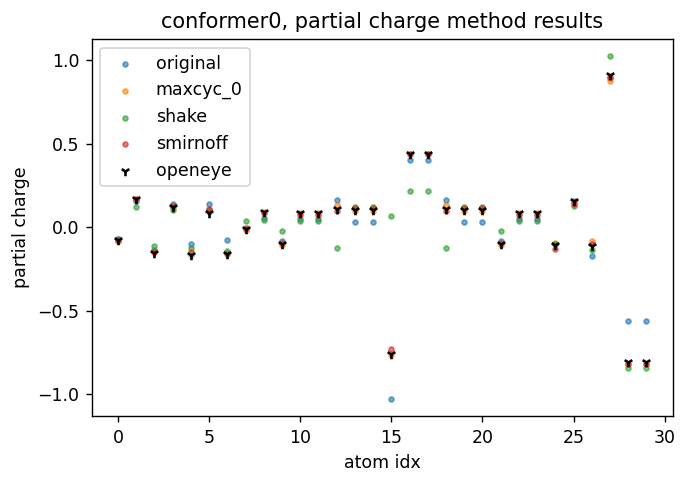

<Figure size 432x288 with 0 Axes>

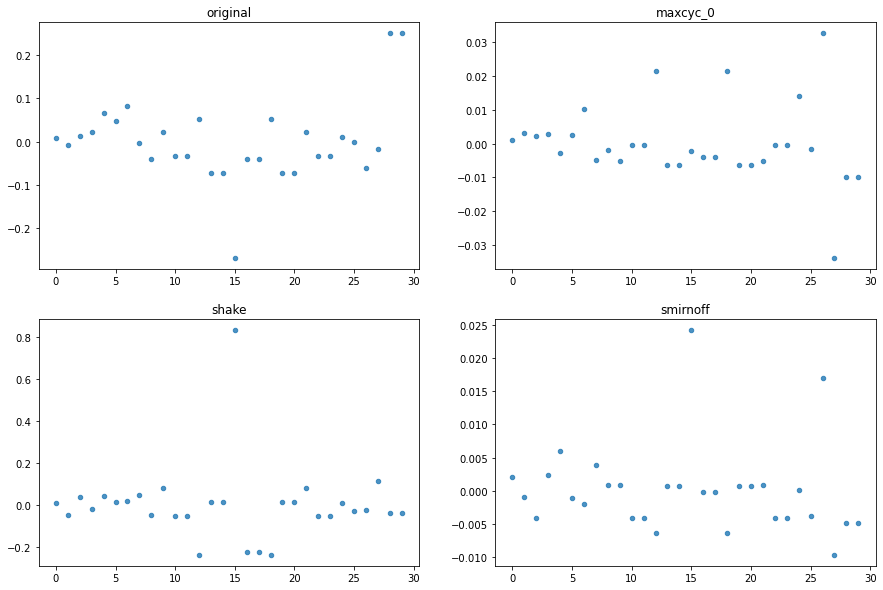

In [18]:

plt.figure(1, dpi=125)
ax1 = plt.subplot(1,1,1)
ax1.set_title("conformer0, partial charge method results")
ax1.set_xlabel("atom idx")
ax1.set_ylabel("partial charge")
amber_dfs = {'original': df_original,
             'maxcyc_0': df_maxcyc_0,
             'shake': df_shake,
             'smirnoff': df_smirnoff}
for method, df in amber_dfs.items():
    ax1.scatter(df.index, df['amber_conf1'], s=8, alpha=0.6, label=method)

ax1.scatter(df_original.index, df_original['oe_conf1'], s=30, alpha=1, label='openeye', marker="1", c='k')

plt.legend()

# using openeye as the "standard", we can look at the deviation from openeye results
plt.figure(2)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for ax, method, df in zip(axs.flat, amber_dfs.keys(), amber_dfs.values()):
    difference = df['amber_conf1'] - df['oe_conf1']
    ax.scatter(difference.index, difference, s=20, alpha=0.8)
    ax.set_title(method)

plt.show()

The outlier in each of these plots is in atom_idx 15. This is a nitrogen. Right now, it is unkown why this atom is giving such a negative partial charge through openeye. It has been highlighted yellow in all previous molecular graphs. Here are the partial charges for that atom using each method:  

In [12]:
print('assigned partial charges for second conformer, atom 15 (nitrogen)')
print('openeye: ' + str(df_original['oe_conf1'].iloc[15]))
print('original amber: ' + str(df_original['amber_conf1'].iloc[15]) + "---> \
recall that rearrangement occured on this nitrogen!")
print('maxcyc_0: ' + str(df_maxcyc_0['amber_conf1'].iloc[15]))
print('shake: ' + str(df_shake['amber_conf1'].iloc[15]))
print('smirnoff: ' + str(df_smirnoff['amber_conf1'].iloc[15]))

assigned partial charges for second conformer, atom 15 (nitrogen)
openeye: -0.7627000212669373
original amber: -1.031---> recall that rearrangement occured on this nitrogen!
maxcyc_0: -0.032
shake: 0.069
smirnoff: 0.043


# Testing on 725 molecules

In [2]:

open("status_results.txt","w").write("")

for mol, fetch_status in ProgressBar(MolDatabase(45)):
    output_dir_str = 'database_cases'
    output_dir = Path.cwd() / output_dir_str
    try:
        mol.generate_conformers(n_conformers=5, toolkit_registry = OpenEyeToolkitWrapper())
    except Exception:
        print(f"OpenEye could not generate conformers for {mol.name}.", end='\t')
        try:
            mol.generate_conformers(n_conformers=5, toolkit_registry = RDKitToolkitWrapper())
            print("Conformers generated with RDKit successfully")
        except Exception:
            print(f"\tRDKit also could not generate conformers for {mol.name}. Continuing with single conformer")
    status = run_am1_bcc(mol, output_dir=f"{output_dir_str}/{mol.name}", arguments=['-ek', 'maxcyc=0'])
    mol_dir = output_dir / f"{mol.name}"
    line = ""
    for conf in status.keys():
        if status[conf] == True:
            conf_dir = mol_dir / conf
            shutil.rmtree(str(conf_dir))
        else:
            line = line + "\t" + conf
    if not any(mol_dir.iterdir()):
        mol_dir.rmdir()

    open("status_results.txt","a").write(f"{mol.name}\t{line}\n")
        
    

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): DrugBank_2987
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 16, aromatic: False, chiral: True
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 28, aromatic: False, chiral: False

parsing /home/coda3831/openff-workspace/openforcefield/openff/toolkit/data/molecules/MiniDrugBank.sdf
Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): DrugBank_3502
Problematic atoms are:
Atom atomic num: 7, name: , idx: 20, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomi

KeyboardInterrupt: 

In [19]:
input_file1 = r'database_cases/ASP_ARG-15/conf2/input_ASP_ARG-15.sdf'
input_file3 = r'database_cases/ASP_ARG-15/conf2/sqm_ASP_ARG-15.pdb'

viewer1 = mol_file_viewer(input_file1, highlight_idx=[])
viewer3 = mol_file_viewer(input_file3, highlight_idx=[])

print("original molecule")
viewer1.show()
print("final molecule after simulation")
viewer3.show()


Exception: Unable to read molecule from file: database_cases/ASP_ARG-15/conf2/input_ASP_ARG-15.sdf

# testing on proteins

The following examples were found and imported from the amberff-porting repo. These residues were found to be particularly prone to this type of error. 

In [ ]:
# copying necessary files to a local directory
import shutil

protein_db = Path('/home/coda3831/openff-workspace/amber-ff-porting/parameter_deduplication/amber-ff-porting')
dest = Path('/home/coda3831/openff-workspace/am1_bcc_scheme/protein_cases/input')

problem_mols = {'CTerminal': {'GLU': 0, 'ASP': 0},
                'NTerminal': {'LYS': 0, 'HIP': 0, 'ARG': 0}}
num_copies = {'GLU': 0, 'ASP': 0, 'LYS': 0, 'HIP': 0, 'ARG': 0} 
max_copies = 1
for file_path in protein_db.glob("**/*.mol2"):
    name = file_path.parents[0]
    name = os.path.basename(name)
    protein_type = file_path.parents[1]
    protein_type = os.path.basename(protein_type)
    # a weird string comparison that gets all troublsome proteins from the database 
    try:
        for res in problem_mols[protein_type].keys():
            if res in name:
                names = name.split("_")
                if problem_mols[protein_type][res] <= max_copies:
                    shutil.copy(file_path, dest)
                    problem_mols[protein_type][res] += 1
                    break
                if len(names) <= 1 or names[0] == names[1]:
                    shutil.copy(file_path, dest)
                    break
    except KeyError:
        continue

I also manually deleted a few mol2 files that were duplicates and would have added time

Finally, run comparison of every conformer for each potein molecule and store the results

In [ ]:
protein_cases = Path('/home/coda3831/openff-workspace/am1_bcc_scheme/protein_cases')
input = protein_cases / 'input'
output = protein_cases / 'output'
for mol_file in input.iterdir():
    if mol_file.is_file() and mol_file.suffix == ".mol2":
        rel_input_path = str(mol_file.relative_to(Path.cwd()))
        rel_output_path = str(output.relative_to(Path.cwd()))

        mol = Molecule.from_file(rel_input_path, file_format="MOL2", allow_undefined_stereo=True)
        mol.name = mol_file.stem
        # since openeye does not work 100% of the time (for some presently unknown reason), first try to use
        # openeye. When openeye fails, default to rdkit conformer generation
        format_len = int((101 - len(mol.name))/2)
        print("_"*format_len + mol.name + "_"*format_len)
        try:
            mol.generate_conformers(n_conformers=5, toolkit_registry = OpenEyeToolkitWrapper())
        except Exception:
            print(f"OpenEye could not generate conformers for {mol.name}.", end='\t')
            try:
                mol.generate_conformers(n_conformers=5, toolkit_registry = RDKitToolkitWrapper())
                print("Conformers generated with RDKit successfully")
            except Exception:
                print(f"\tRDKit also could not generate conformers for {mol.name}. Continuing with single conformer")
        # run am1-bcc and print info on success or failure 
        status = run_am1_bcc(mol, output_dir=f'{rel_output_path}/{mol_file.stem}')
        print(status)




## Animation of Original Test Case Charges (no restraint)
Maybe stick all of this into a class for use on the other molecules? 

In [20]:
# %matplotlib inline
%matplotlib widget
from IPython.display import HTML
def charge_data(charge_folder = "animation/conf0/charge_frames"):
    #returns a numpy array of charge data
    charge_folder = Path.cwd() / charge_folder
    if not charge_folder.exists():
        print("could not find charge folder")
        return None
    
    # get first file for the shape argument
    first_file = next(charge_folder.iterdir())
    with open(first_file, "r") as f_file:
        charge_info = f_file.read().split()
        array_width = len(charge_info)
    charges_array = np.empty(dtype=float, shape=[0, array_width])
    i = 0
    for file in charge_folder.iterdir():
        i+=1
        with open(file, "r") as in_file:
            charge_info = in_file.read().split()
        charges = [float(i) for i in charge_info]
        charges_array = np.concatenate((charges_array, [charges]), axis=0)
    return charges_array
data = charge_data("solution_testing/smiles-as/original/conf0/charge_frames")
height, width = data.shape
x = np.array(range(0, width))

def update_plot(i, data, scat):
    vec = data[i, :]
    scat.set_offsets(np.array([x, vec]).T)

    return scat,

numframes = height
print(height)
# numpoints = 10
# color_data = np.random.random((numframes, numpoints))
# x, y, c = np.random.random((3, numpoints))
plt.clf()
fig = plt.figure(figsize=(9,6))
vec = data[0, :]

scat = plt.scatter(x, vec, s=50)
plt.xlabel("atom idx")
plt.ylabel("partial charge")

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                fargs=(data, scat))

# HTML(ani.to_jshtml())
HTML(ani.to_html5_video())


27


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [3]:
# %matplotlib inline
%matplotlib widget
data = charge_data("solution_testing/smiles-as/original/conf0/charge_frames")
height, width = data.shape
atoms = range(0, width)

def update_plot(i, data, scat):
    for atom in atoms:
        vec = data[:i+1, atom]
        x = range(0, i+1)
        plt.plot(x, vec)

    return scat,

numframes = height
print(height)
# numpoints = 10
# color_data = np.random.random((numframes, numpoints))
# x, y, c = np.random.random((3, numpoints))

plt.clf()
fig = plt.figure(figsize=(9,6))

ani = animation.FuncAnimation(fig, update_plot, frames=range(0, numframes),
                                fargs=(data, scat))

HTML(ani.to_html5_video())

27


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
%matplotlib widget
plt.clf()
import matplotlib.pyplot as plt
from matplotlib import animation

data = charge_data("solution_testing/CTerminal_HIP_ASP-i_2/original/conf0/charge_frames")
height, width = data.shape
atoms = range(0, width)
print(data)

fig = plt.figure(figsize=(9,6))
ax1 = plt.axes(xlim=(0, height), ylim=(-1, 1))
line, = ax1.plot([], [], lw=1)
plt.xlabel('simulation step')
plt.ylabel('partial charge')

lines = []
for index in range(width):
    lobj = ax1.plot([],[],lw=1)[0]
    lines.append(lobj)


def init():
    for line in lines:
        line.set_data([],[])
    return lines

xlist = []
ylist = []
for ix in range(0, width):
    xlist.append([])
    ylist.append([])

def animate(i):
    #for index in range(0,1):
    for lnum,line in enumerate(lines):
        ylist[lnum].append(data[i, lnum])
        xlist[lnum].append(i)
        line.set_data(xlist[lnum], ylist[lnum]) # set data for each line separately. 

    return lines

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0, height), blit=False)


HTML(anim.to_html5_video())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[[-0.1591  0.6591 -0.6711 ...  0.1057  0.0197  0.0057]
 [-0.1741  0.6651 -0.6881 ...  0.0787  0.0177 -0.0063]
 [-0.1731  0.6651 -0.6851 ...  0.0907  0.0187 -0.0043]
 ...
 [-0.1711  0.6651 -0.6871 ...  0.0597  0.0327  0.0747]
 [-0.1711  0.6651 -0.6871 ...  0.0597  0.0327  0.0747]
 [-0.1711  0.6651 -0.6871 ...  0.0597  0.0327  0.0747]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# database solution testing plots

In [40]:
methods = ["original",
            "maxcyc_0",
            "shake",
            "smirnoff",
            "openeye"]
output_dir_str = 'solution_testing'
delim = ","
columns = methods + ["conf", "isomorphic"]
df = pd.DataFrame(columns=columns)

for method in methods:
    with open(f"{output_dir_str}/{method}_{output_dir_str}_status_results.txt","r") as file:
        lines = file.read().split('\n')
    for line in lines:
        info = line.split(delim)
        name = info[0]
        if name == "":
            break
        conf = info[1]
        name = name + "_conf" + conf
        conf = int(conf)
        info = info[2:]
        if method == "openeye":
            info = [i[:-2] for i in info]
        
        charges = [float(i) for i in info if (i != "True" and i !="False")]
        
        df.at[name, method] = charges
        df.at[name, "conf"] = conf
        if method == "original":
            status = [(i=="True") for i in info if (i == "True" or i =="False")]
            status = any(status)
            df.at[name, "isomorphic"] = status
# due to alignment error, will fix later
df.dropna(inplace=True)


In [19]:
df

,original,maxcyc_0,shake,smirnoff,openeye,conf,isomorphic
CTerminal_ARG_ASP-a_1_conf0,"[-0.1751, 0.6551, -0.6501, -0.5409, 0.0227, -0...","[-0.1521, 0.6421, -0.6501, -0.5499, 0.0507, -0...","[-0.1751, 0.6551, -0.6501, -0.5409, 0.0227, -0...","[-0.1671, 0.6511, -0.6391, -0.5469, 0.0207, -0...","[-0.1662600040435791, 0.6504200100898743, -0.6...",0,True
CTerminal_ARG_ASP-a_1_conf1,"[-0.1801, 0.6561, -0.6661, -0.5099, -0.0093, -...","[-0.1721, 0.6571, -0.6221, -0.5569, 0.0807, -0...","[-0.1801, 0.6561, -0.6661, -0.5099, -0.0093, -...","[-0.1671, 0.6471, -0.6341, -0.5419, 0.0227, -0...","[-0.17205999791622162, 0.6451799869537354, -0....",1,True
CTerminal_ARG_ASP-a_1_conf2,"[-0.1781, 0.6441, -0.6351, -0.5129, -0.0023, -...","[-0.1601, 0.6601, -0.6471, -0.5579, 0.0367, -0...","[-0.1781, 0.6441, -0.6351, -0.5129, -0.0023, -...","[-0.1691, 0.6441, -0.6341, -0.5349, 0.0117, -0...","[-0.1699800044298172, 0.6505900025367737, -0.6...",2,True
CTerminal_ARG_ASP-a_4_conf0,"[-0.1761, 0.6791, -0.6851, -0.5519, -0.0293, -...","[-0.1631, 0.6561, -0.6331, -0.5589, 0.0617, -0...","[-0.1761, 0.6791, -0.6851, -0.5519, -0.0293, -...","[-0.1611, 0.6591, -0.6101, -0.5879, 0.0597, -0...","[-0.16202999651432037, 0.6390200257301331, -0....",0,True
CTerminal_ARG_ASP-a_4_conf1,"[-0.1741, 0.6651, -0.6131, -0.5809, 0.0347, -0...","[-0.1551, 0.6471, -0.6151, -0.5959, 0.0687, -0...","[-0.1741, 0.6651, -0.6131, -0.5809, 0.0347, -0...","[-0.1621, 0.6591, -0.6051, -0.5939, 0.0617, -0...","[-0.1670600026845932, 0.6562399864196777, -0.6...",1,True
CTerminal_ARG_ASP-a_4_conf2,"[-0.1741, 0.6631, -0.6071, -0.5719, 0.0387, -0...","[-0.1521, 0.6371, -0.5491, -0.6039, 0.0957, -0...","[-0.1741, 0.6631, -0.6071, -0.5719, 0.0387, -0...","[-0.1631, 0.6601, -0.6061, -0.5929, 0.0607, -0...","[-0.16913999617099762, 0.6346700191497803, -0....",2,True
CTerminal_ARG_ASP-a_3_conf0,"[-0.1751, 0.6531, -0.6251, -0.5369, 0.0127, -0...","[-0.1511, 0.6501, -0.6401, -0.5689, 0.0657, -0...","[-0.1751, 0.6531, -0.6251, -0.5369, 0.0127, -0...","[-0.1661, 0.6551, -0.6271, -0.5599, 0.0437, -0...","[-0.16585999727249146, 0.6530799865722656, -0....",0,True
CTerminal_ARG_ASP-a_3_conf1,"[-0.1751, 0.6591, -0.6511, -0.5439, 0.0217, -0...","[-0.1561, 0.6611, -0.6191, -0.5749, 0.0587, -0...","[-0.1751, 0.6591, -0.6511, -0.5439, 0.0217, -0...","[-0.1691, 0.6561, -0.6491, -0.5379, 0.0307, -0...","[-0.16859999299049377, 0.6497399806976318, -0....",1,True
CTerminal_ARG_ASP-a_3_conf2,"[-0.1781, 0.6581, -0.6271, -0.5389, 0.0427, -0...","[-0.1541, 0.6481, -0.5611, -0.6029, 0.0987, -0...","[-0.1781, 0.6581, -0.6271, -0.5389, 0.0427, -0...","[-0.1661, 0.6511, -0.6241, -0.5669, 0.0477, -0...","[-0.16693000495433807, 0.6357600092887878, -0....",2,True
CTerminal_ARG_ASP-a_3_conf3,"[-0.1751, 0.6541, -0.6301, -0.5489, 0.0277, -0...","[-0.1621, 0.6561, -0.6361, -0.5619, 0.0577, -0...","[-0.1751, 0.6541, -0.6301, -0.5489, 0.0277, -0...","[-0.1671, 0.6481, -0.6211, -0.5489, 0.0377, -0...","[-0.16705000400543213, 0.6517300009727478, -0....",3,True


In [41]:
%%capture
plots = Path(Path.cwd() / "plots")
plots.mkdir(exist_ok=True)
Path(plots / "isomorphic").mkdir(exist_ok=True, parents=True)
Path(plots / "not_isomorphic").mkdir(exist_ok=True, parents=True)

i=0
plt.rcParams['savefig.facecolor']='white'
for name, row in df.iterrows():
    # if i != 0:
    #     break
    box_data = []
    for method in methods[0:4]:
        differences = []
        openeye_data = row['openeye']
        method_data = row[method]
        for openeye_charge, method_charge in zip(openeye_data, method_data):
            differences.append(method_charge-openeye_charge)
        box_data.append(differences)
    isomorphic = row['isomorphic']

    method_differences = dict(zip(methods[0:4], box_data))
    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(15,10))
    if isomorphic:
        title = f"{name} partial charge differences from openeye\nNo connectivity change detected"
    else:
        title = f"{name} partial charge differences from openeye\n********Connectivity change detected********"
    fig.suptitle(title)
    # maxcyc_0 method
    axs[1,0].scatter(range(0, len(method_differences['maxcyc_0'])), method_differences['maxcyc_0'], s=10, alpha=0.7)
    axs[1,0].set_title('maxcyc_0')
    # smirnoff method
    axs[1,1].scatter(range(0, len(method_differences['smirnoff'])), method_differences['smirnoff'], s=10, alpha=0.7)
    axs[1,1].set_title('smirnoff')
    axs[1,0].get_shared_y_axes().join(axs[1,0], axs[1,1])
    axs[1,0].grid(True)
    axs[1,1].grid(True)
    # original method
    axs[0,1].scatter(range(0, len(method_differences['original'])), method_differences['original'], s=10, alpha=0.7)
    axs[0,1].set_title('original')
    axs[0,1].grid(True)
    # summary boxplot
    axs[0,0].boxplot(box_data, labels=methods[:4])
    axs[0,0].grid(True)
    i += 1

    if isomorphic:
        plt.savefig(f"plots/isomorphic/{name}.png")
    else:
        plt.savefig(f"plots/not_isomorphic/{name}.png")





In [ ]:
data = charge_data("solution_testing/CTerminal_ARG_ASP-a/")

In [39]:
i = 0
for mol, fetch_status in MolDatabase():
    i += 1
    
i

parsing /home/coda3831/openff-workspace/amber-ff-porting/parameter_deduplication/amber-ff-porting


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 13, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 14, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 17, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: False
Atom atomic num: 16, name: , idx: 29, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 4, aromatic: True, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 30, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False



parsing .


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): smiles-ak_1
Problematic atoms are:
Atom atomic num: 16, name: , idx: 17, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 3, aromatic: True, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 18, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 19, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 34, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 31, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 35, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, nam

Unable to make OFFMol from OEMol: OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 10, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 8, name: , idx: 11, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 12, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 21, aromatic: False, chiral: False

failed molecule in smiles


Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 6, name: , idx: 24, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 7, name: , idx: 9, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 26, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 25, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 1, name: , idx: 43, aromatic: False, chiral: False

Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 7, name: , idx: 18, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 15, aromatic: False, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 2

182